In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical 
from keras.layers import Dropout ,Flatten 
from keras.layers.convolutional import Conv2D , MaxPooling2D
import pickle
import pandas as pd 
import random
import cv2

Using TensorFlow backend.


In [2]:
np.random.seed(0)


In [3]:
#git clone https://bitbucket.org/jadslim/german-traffic-signs

In [4]:
path = "master"

In [22]:
with open('master/train.p','rb') as f :
  train_data = pickle.load(f)
with open('master/valid.p','rb') as f :
  val_data = pickle.load(f)
  
with open('master/test.p','rb') as f :
  test_data = pickle.load(f)
  
print(type(train_data))
     
X_train , y_train = train_data['features'] , train_data['labels']
X_val , y_val  = val_data['features'] , val_data['labels']
X_test , y_test = test_data['features'] , test_data['labels']


<class 'dict'>


In [23]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [24]:
assert(X_train.shape[0] == y_train.shape[0]) , "Error the number of images does not equal the number of labels"
assert(X_test.shape[0] ==y_test.shape[0]) , "Error the number of images does not equal the number of labels"
assert(X_test.shape[0] == y_test.shape[0]) , "Error the number of images does not equal the number of labels"

assert(X_train.shape[1:] == (32,32,3)) , "the dimension of images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)) , "the dimension of images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)) , "the dimension of images are not 32x32x3"

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

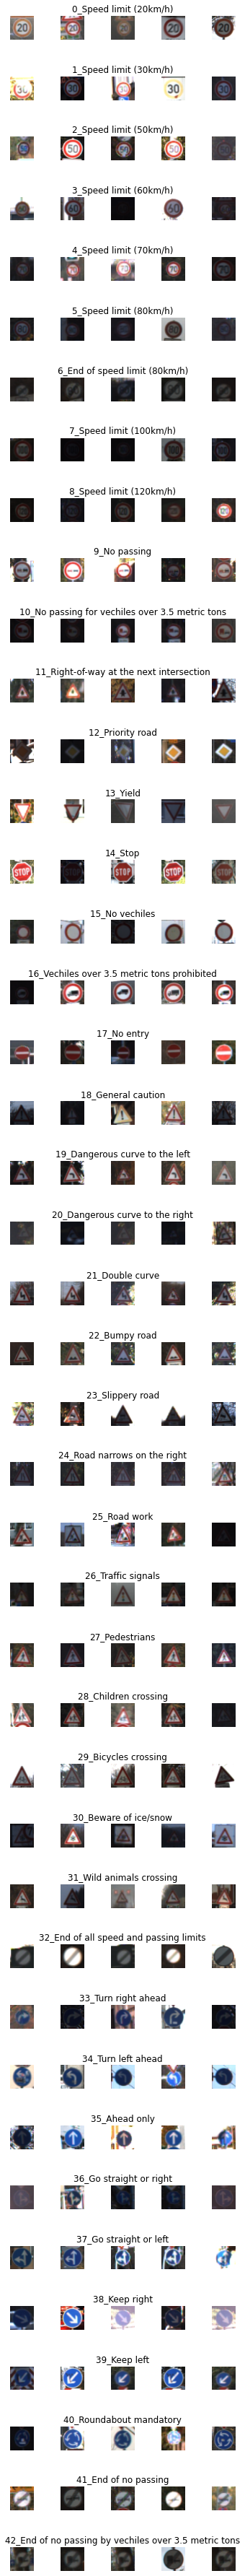

In [25]:
data = pd.read_csv('master/signnames.csv')
print(data)
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols) :
    for j , row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" +row['SignName'])
            num_of_samples.append(len(x_selected))


Text(0, 0.5, '# of images')

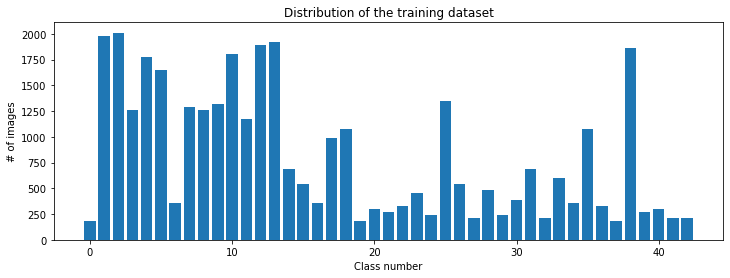

In [26]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("# of images")

(32, 32, 3)
36


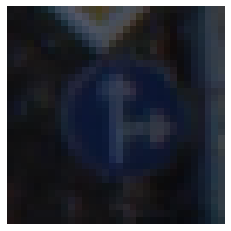

In [27]:
import cv2 
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

(32, 32, 3)
(32, 32)


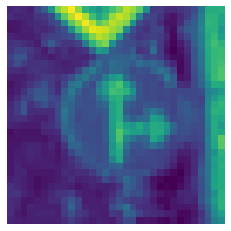

In [28]:
#convert to grayscale 
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img 
print(X_train[1000].shape)
img = grayscale(X_train[1000])

plt.imshow(img)
plt.axis('off')
print(img.shape)

(-0.5, 31.5, 31.5, -0.5)

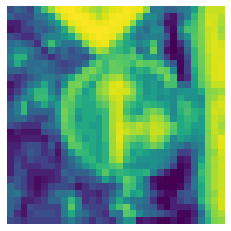

In [29]:
def equalize_hist(img):
 img = cv2.equalizeHist(img)
 return img
img = equalize_hist(img)
plt.imshow(img)
plt.axis('off')


In [30]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize_hist(img)
  img= img/255
  return img 
X_train  = np.array(list(map(preprocessing,X_train)))
X_val  = np.array(list(map(preprocessing,X_val)))
X_test  = np.array(list(map(preprocessing,X_test)))


(34799, 32, 32)


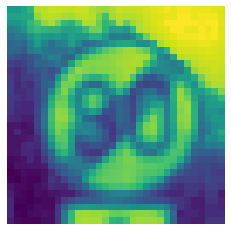

In [31]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [32]:
X_train = X_train.reshape(34799, 32, 32 , 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [33]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range = 0.2,
                             shear_range= 0.15,
                             rotation_range = 30) 
datagen.fit(X_train)

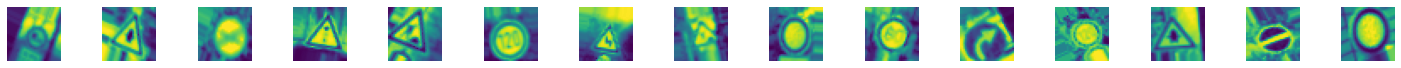

In [ ]:
batches = datagen.flow(X_train,y_train,batch_size = 20)
X_batch , y_batch = next(batches)
fig , axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [34]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [35]:
y_train  = to_categorical(y_train, 43)
y_val  = to_categorical(y_val, 43)
y_test  = to_categorical(y_test, 43)
print(y_train.shape)

(34799, 43)


In [36]:
def model():
  model  = Sequential()
  
  model.add(Conv2D(60,(5,5),input_shape = (32,32,1) , activation = 'relu'))
  model.add(Conv2D(60,(5,5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))#(2,2) i.e 32x32x1 ---> 16x16x1
  
  model.add(Conv2D(30,(3,3),activation = 'relu'))
  model.add(Conv2D(30,(3,3),activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))  
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500,activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation = 'softmax'))
  return model

In [37]:
model = model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [38]:
print('Starting training.....')
history  = model.fit_generator(datagen.flow(X_train , y_train , batch_size = 50), steps_per_epoch = 2000,epochs = 10,validation_data=(X_val,y_val),shuffle = 1 ,verbose = 1 ) 

Starting training.....
Epoch 1/10
 225/2000 [==>...........................] - ETA: 11:17 - loss: 3.3764 - accuracy: 0.0961

KeyboardInterrupt: 

In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

In [ ]:

model_path = "/content/drive/MY Drive/saved_model"
if not os.path.exists(model_path):
    os.mkdir(model_path)
model.save(os.path.join(model_path,"traffic_sign_model.h5"))

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

In [ ]:
# download to google drive                       
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1aybB8WRtJ4gi1ptv5z8zJU3__i-MBSh7'})

In [ ]:
file_obj = drive.CreateFile({'id': '16zbkEN4vqnPvIOvLMF1IaXKYCq5g3Yln'})                       
file_obj.GetContentFile('keras.h5')

ApiRequestError: ignored

Text(0.5, 0, 'epoch')

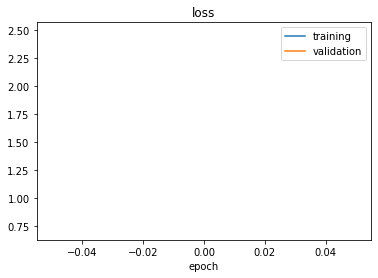

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training' , 'validation'])
plt.title('loss')
plt.xlabel('epoch')

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training' , 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

KeyError: ignored

In [ ]:
score =  model.evaluate(X_test,y_test,verbose = 1)
print('Test score: ' , score[0])
print('Test accuracy: ' , score[1])

#there is two  things to correct : accuracy , overfitting 

In [ ]:
import requests
import cv2
from PIL import Image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSq2yVX_FxsRNF6VFgyxFFqaxpf6aZ3sbjWaONlneQHX768CTSEtA'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

 

In [ ]:
img = img.reshape(1, 32, 32, 1)


In [ ]:
print("predicted sign: "+ str(model.predict_classes(img)))

In [ ]:
model.save('trafic_sign.h5')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
data_dir = '/content/gdrive/My Drive/model.h5'

from keras.models import load_model
model = load_model(data_dir)

In [ ]:
import requests
import cv2
from PIL import Image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQpGkayiSC6ANtUMLeJkIiJqsNRvTIkD9CahxnwZtyRWVAYvO27'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)


In [ ]:
img = img.reshape(1, 32, 32, 1)


In [ ]:
print("predicted sign: "+ str(model.predict_classes(img)))